# Image classification: cats & dogs

In [1]:
# Handle imports up-front
import os
import sys
import glob
import random

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Use a specific GPU on multiGPU systems, if desired
os.environ['CUDA_VISIBLE_DEVICES']='1'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import image from keras correctly based on the TensorFlow version
tf_version=float('.'.join(tf.__version__.split('.')[0:2]))

if tf_version > 2.8:
    import keras.utils as image

else:
    from keras.preprocessing import image

# Figure out if we are running on Kaggle or not, if so
# add the location of utils.py to path so we can import
path_list=os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')

# Import custom helper functions from utils.py
from image_classification_functions import prep_data
from image_classification_functions import single_training_run
from image_classification_functions import plot_single_training_run
from image_classification_functions import hyperparameter_optimization_run
from image_classification_functions import plot_hyperparameter_optimization_run

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')

# Limit TensorFlow's CPU usage
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Decompress and organize the images
training_data_path, validation_data_path, testing_data_path=prep_data()

# Get lists of training and validation dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats=glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs=glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats=glob.glob(f'{validation_data_path}/cats/cat.*')

Not running in Kaggle notebook
Checking data prep
Data prep already complete


### 1.2. Inspect

#### 1.2.1. Training images

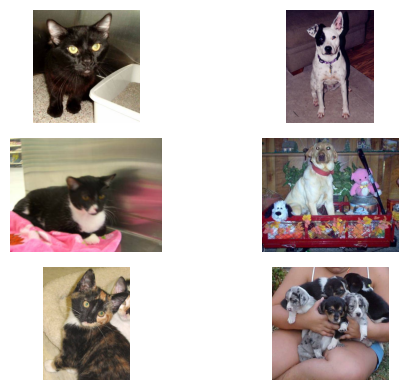

In [3]:
# Plot some of the cat and dog images
fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

#### 1.2.1. Validation images

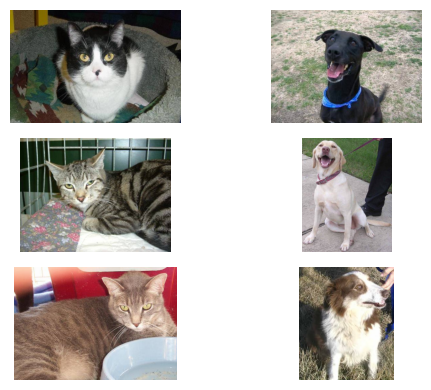

In [4]:
# Plot some of the cat and dog images
fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(validation_cats, validation_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

## 2. EDA

Let's take a deeper look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [5]:
# Load one of the dogs
dog=image.load_img(training_dogs[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog=image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (499, 385, 3)


The data has shape of 375 x 499 x 3? The image is 375 x 499 pixels, that makes sense. But what is the 3? Let's plot the pixel values and you will see what is going on:

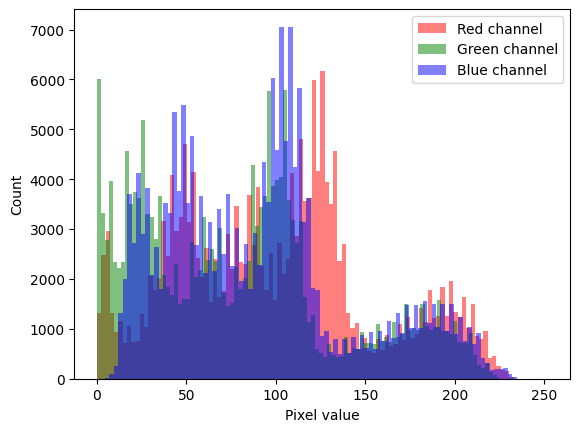

In [6]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

There are a few interesting observations we can make here:

1. This array has 3 axes: 375 x 499 x 3. The first two are the dimensions of the image, the third is the three color channels: red, green and blue.
2. 375 x 499 x 3 is over a half million individual values - this one image is 10 time more data that any of the other datasets we have worked with so far!
3. The range of pixel values is from 0 to about 250 - in reality it is (0,255) for a total range of 256 possible values per pixel. This is defined by the JPEG image standard.

There are two things we can do with this information. First, we should scale the pixel values, this will improve the training of our neural network. We can do this directly in the model definition by adding a normalization layer. Second, we can make the images gray scale, which will decrease the input size and therefore computational burden by a factor of three. We can do this via the image dataset generator.

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

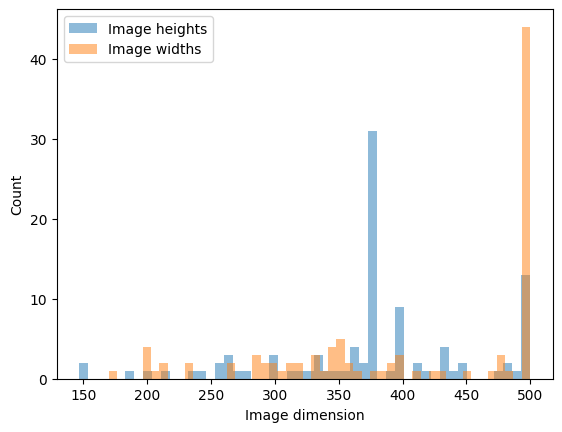

In [7]:
# Get a random sample of images, half cats and half dogs
sample_size=100
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

# Collectors for data
heights=[]
widths=[]

# Loop on the sample images
for sample_image in sample:

    # Load the image and convert it to an array
    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)

    # Get the width and height and add to collections
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

# Plot results as a histogram
plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Based on the above plot, let's set our image dimension at 64 or 128 pixels. Smaller is better for training speed and memory use, but we don't want to go too small, then the model will have a hard time learning from the data. There is no hard and fast rule here. You could do an experiment testing several different image dimensions to see how small we could make the image and still get good performance.

### 2.3. Image aspect ratios

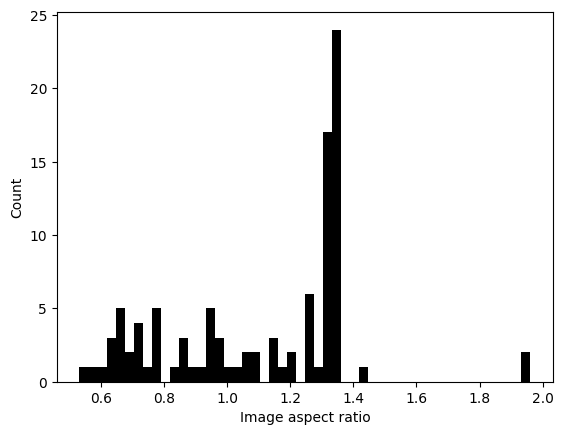

In [8]:
# Calculate the sample image aspect ratios
aspect_ratios=np.array(widths)/np.array(heights)

# Plot as histogram
plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

The most common aspect ratio in the data set looks to be around 1.3 - which is the '4:3' aspect ratio that used to be the standard for computer monitors. Rather than using square input images, we can use this aspect ratio to better match the data.

In [9]:
image_width=64
aspect_ratio=4/3
image_height=int(image_width / aspect_ratio)

## 3. Model

Now it's time to build and train the model. We will do this in a few steps, evaluating performance by looking at the training curves along the way:

1. Establish baseline performance with default settings
2. Optimize the batch size and learning rate
3. Optimize regularization with L1 and L2 penalties
4. Optimize input image size for speed and/or better performance
5. Optimize network architecture
6. Final model and evaluation

First, let's choose some initial settings for how much to train.

In [10]:
epochs=20
steps_per_epoch=50
validation_steps=50

### 3.1. Baseline model performance

Training run already complete, loading results from disk.


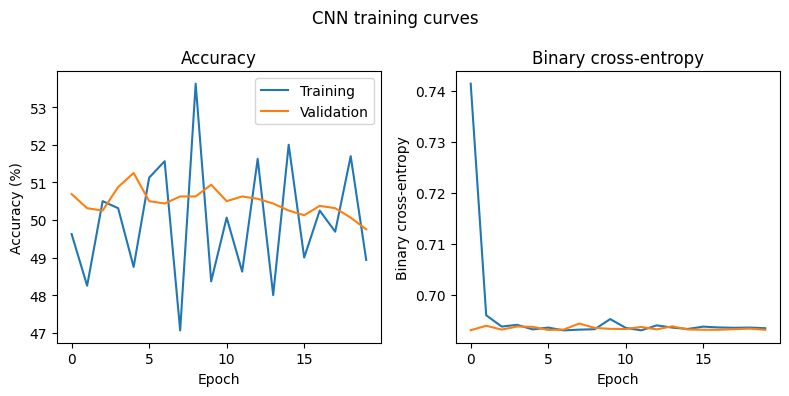


CPU times: user 3.45 s, sys: 732 ms, total: 4.18 s
Wall time: 3.85 s


In [11]:
%%time

# Do a single training run with default settings
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    image_height=image_width,
    image_width=image_height,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    print_model_summary=True
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.2. Batch size and learning rate optimization

Optimization run already complete, loading results from disk.


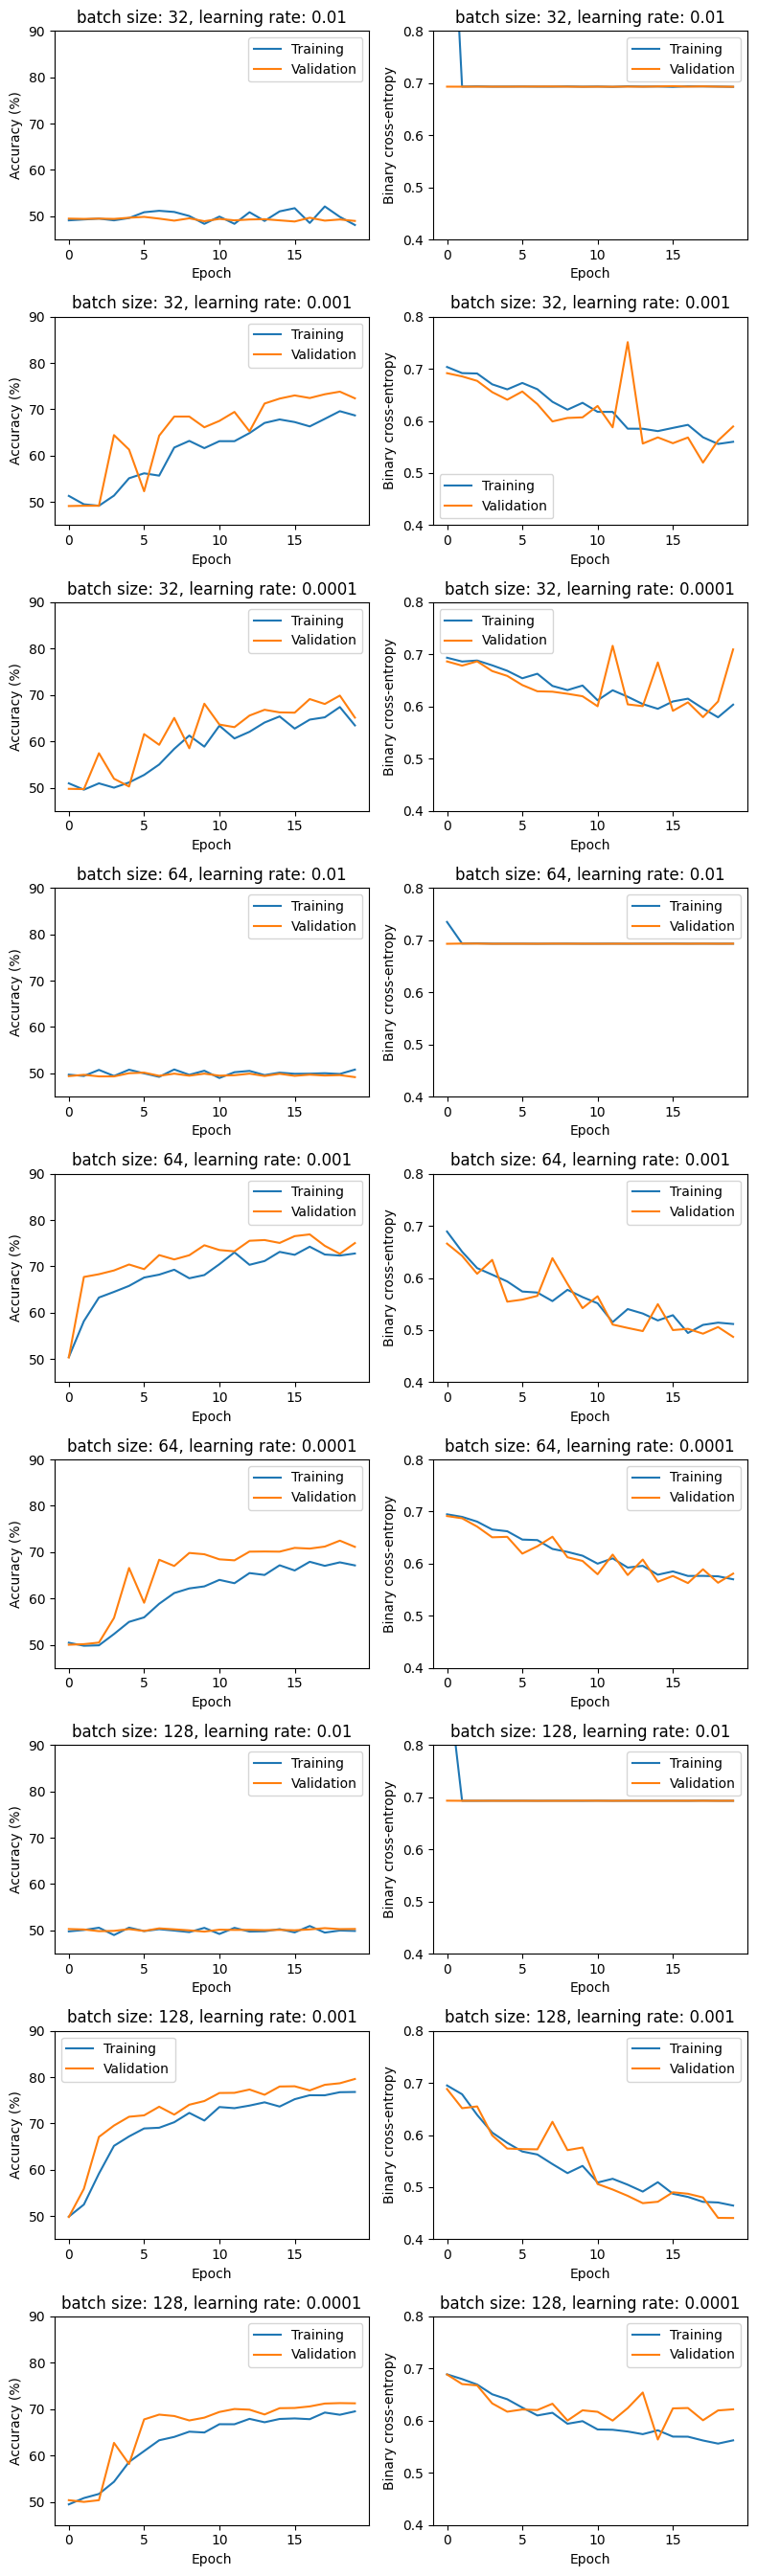


CPU times: user 18.3 s, sys: 634 ms, total: 18.9 s
Wall time: 18.6 s


In [12]:
%%time

# Define hyperparameters
hyperparameters={
    'batch_sizes': [32, 64, 128],
    'learning_rates': [0.01, 0.001, 0.0001],
    'image_widths': [image_width],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': epochs
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['batch_sizes', 'learning_rates']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.4,0.8]
).show()

print()

In [13]:
batch_size=128
learning_rate=0.001

Training run already complete, loading results from disk.


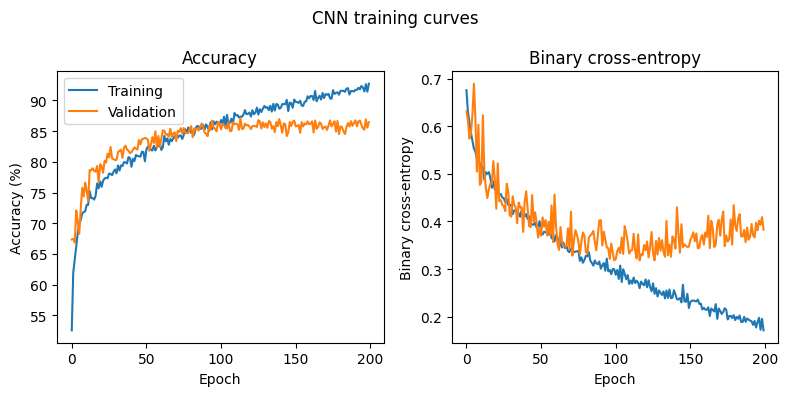


CPU times: user 3.05 s, sys: 358 ms, total: 3.41 s
Wall time: 2.9 s


In [14]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'image_width': image_width,
    'image_height': image_height,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 200
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.3. Regularization

Optimize L1 and L2 penalties using the optimized batch size and learning rate from the previous experiment.

Optimization run already complete, loading results from disk.


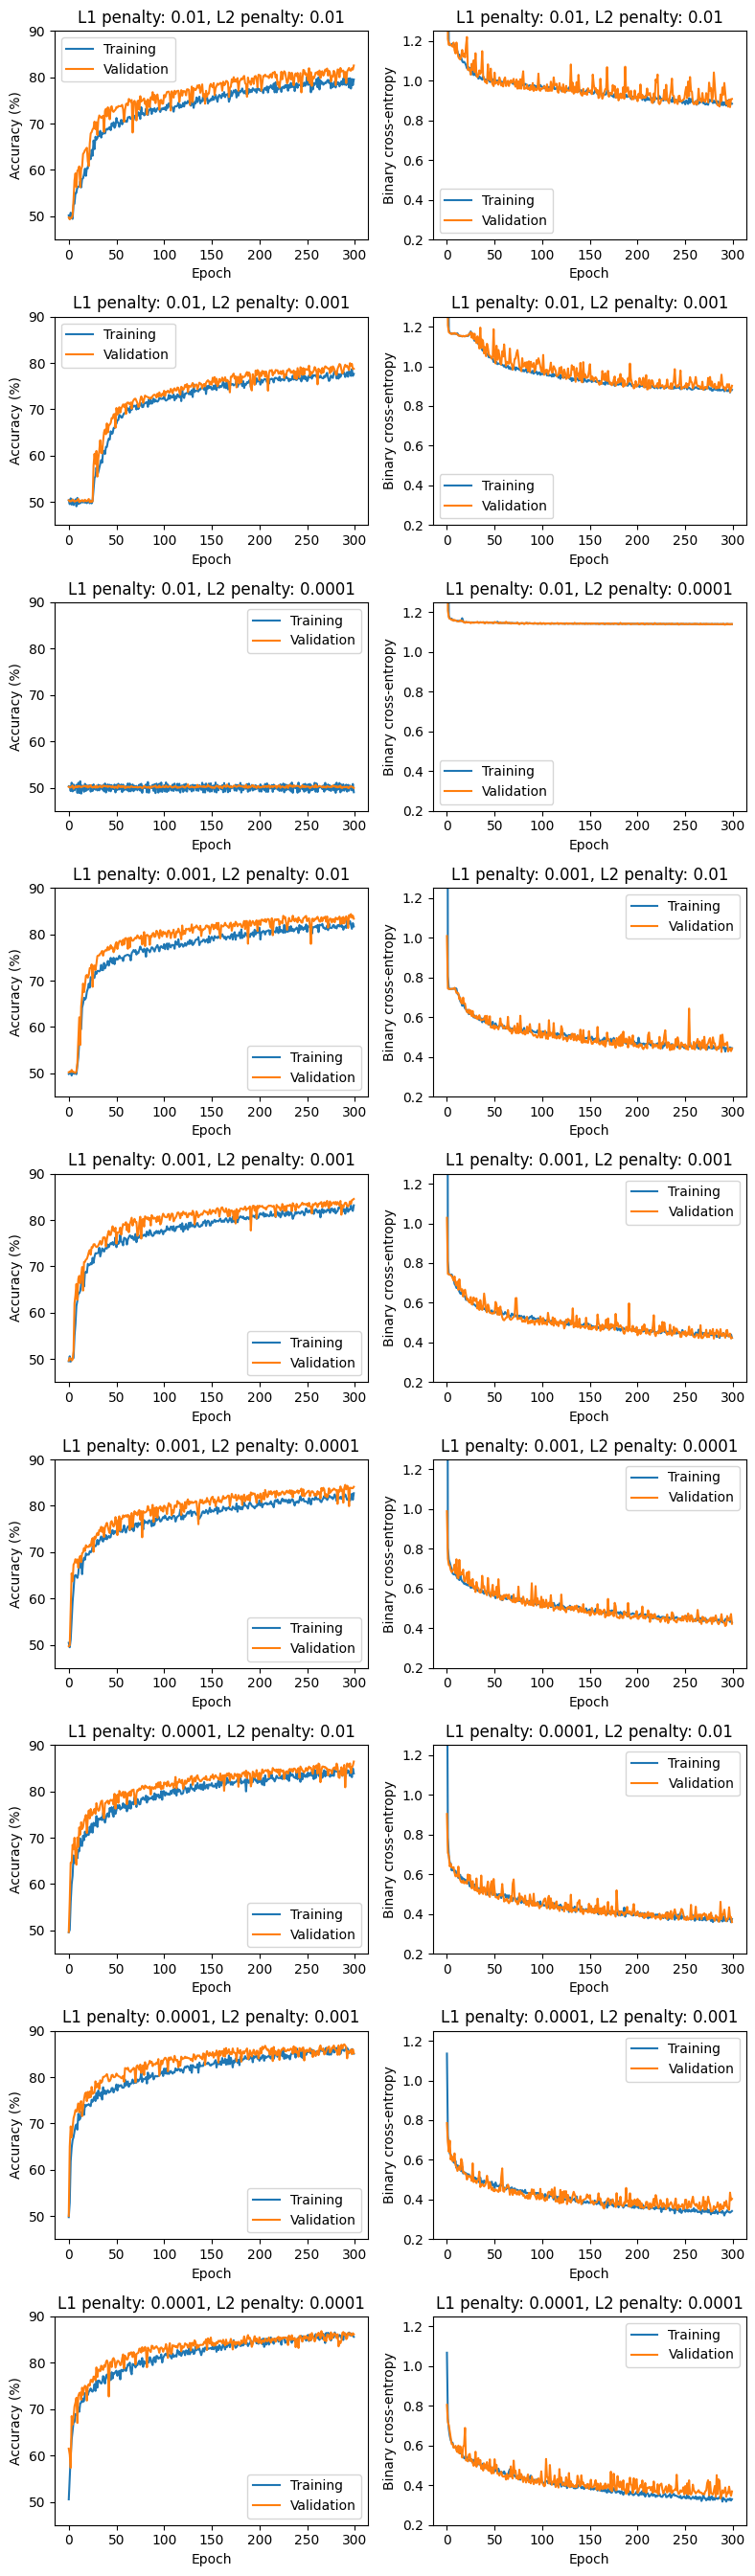


CPU times: user 19.3 s, sys: 683 ms, total: 20 s
Wall time: 19.7 s


In [15]:
%%time

# Define hyperparameters
hyperparameters={
    'l1_penalties': [0.01, 0.001, 0.0001],
    'l2_penalties': [0.01, 0.001, 0.0001],
    'batch_sizes': [batch_size],
    'learning_rates': [learning_rate],
    'image_widths': [image_width],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 300
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['l1_penalties', 'l2_penalties']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.2,1.25]
).show()

print()

In [16]:
l1_penalty=0.001
l2_penalty=0.0001

Training run already complete, loading results from disk.


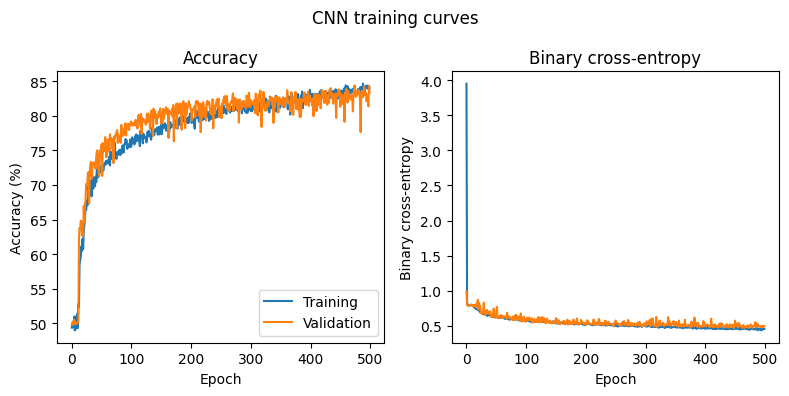


CPU times: user 3.12 s, sys: 372 ms, total: 3.49 s
Wall time: 3.02 s


In [17]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 500
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters,
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.4. Input image size optimization

Try some smaller input image sizes and see how the model does with the hyperparameter settings we have chosen via optimization so far.

Optimization run already complete, loading results from disk.


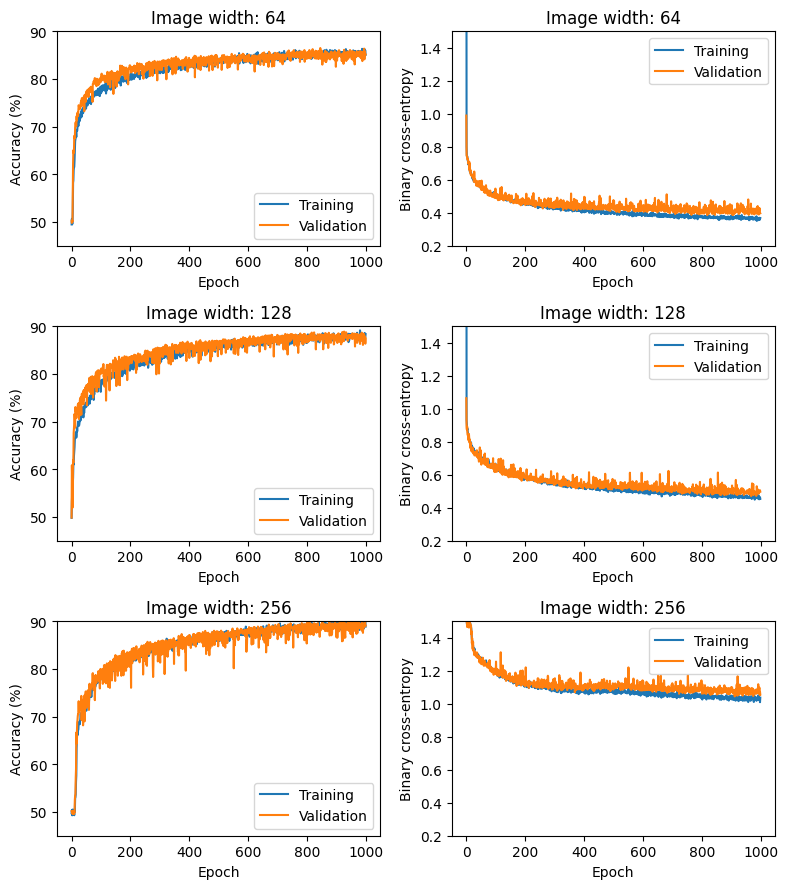


CPU times: user 7.74 s, sys: 577 ms, total: 8.32 s
Wall time: 7.95 s


In [18]:
%%time

# Define hyperparameters
hyperparameters={
    'l1_penalties': [l1_penalty],
    'l2_penalties': [l2_penalty],
    'batch_sizes': [batch_size],
    'learning_rates': [learning_rate],
    'image_widths': [64, 128, 256],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 1000
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['image_widths']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.2,1.5]
).show()

print()

In [19]:
image_width=256
image_height=int(image_width/aspect_ratio)

Training run already complete, loading results from disk.


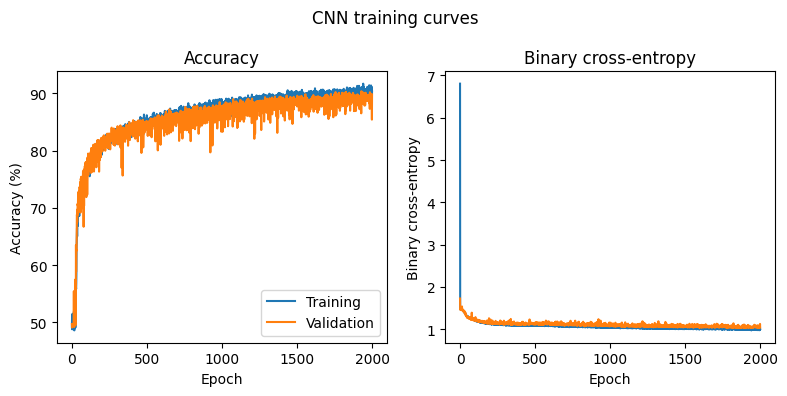


CPU times: user 3.17 s, sys: 540 ms, total: 3.71 s
Wall time: 3.23 s


In [20]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'image_height': image_height,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 2000
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.5. Model architecture

#### 3.5.1. Convolutional layers

Starting training run 1 of 9
Starting training run 2 of 9
Starting training run 3 of 9
Starting training run 4 of 9
Starting training run 5 of 9
Starting training run 6 of 9
Starting training run 7 of 9
Starting training run 8 of 9
Starting training run 9 of 9


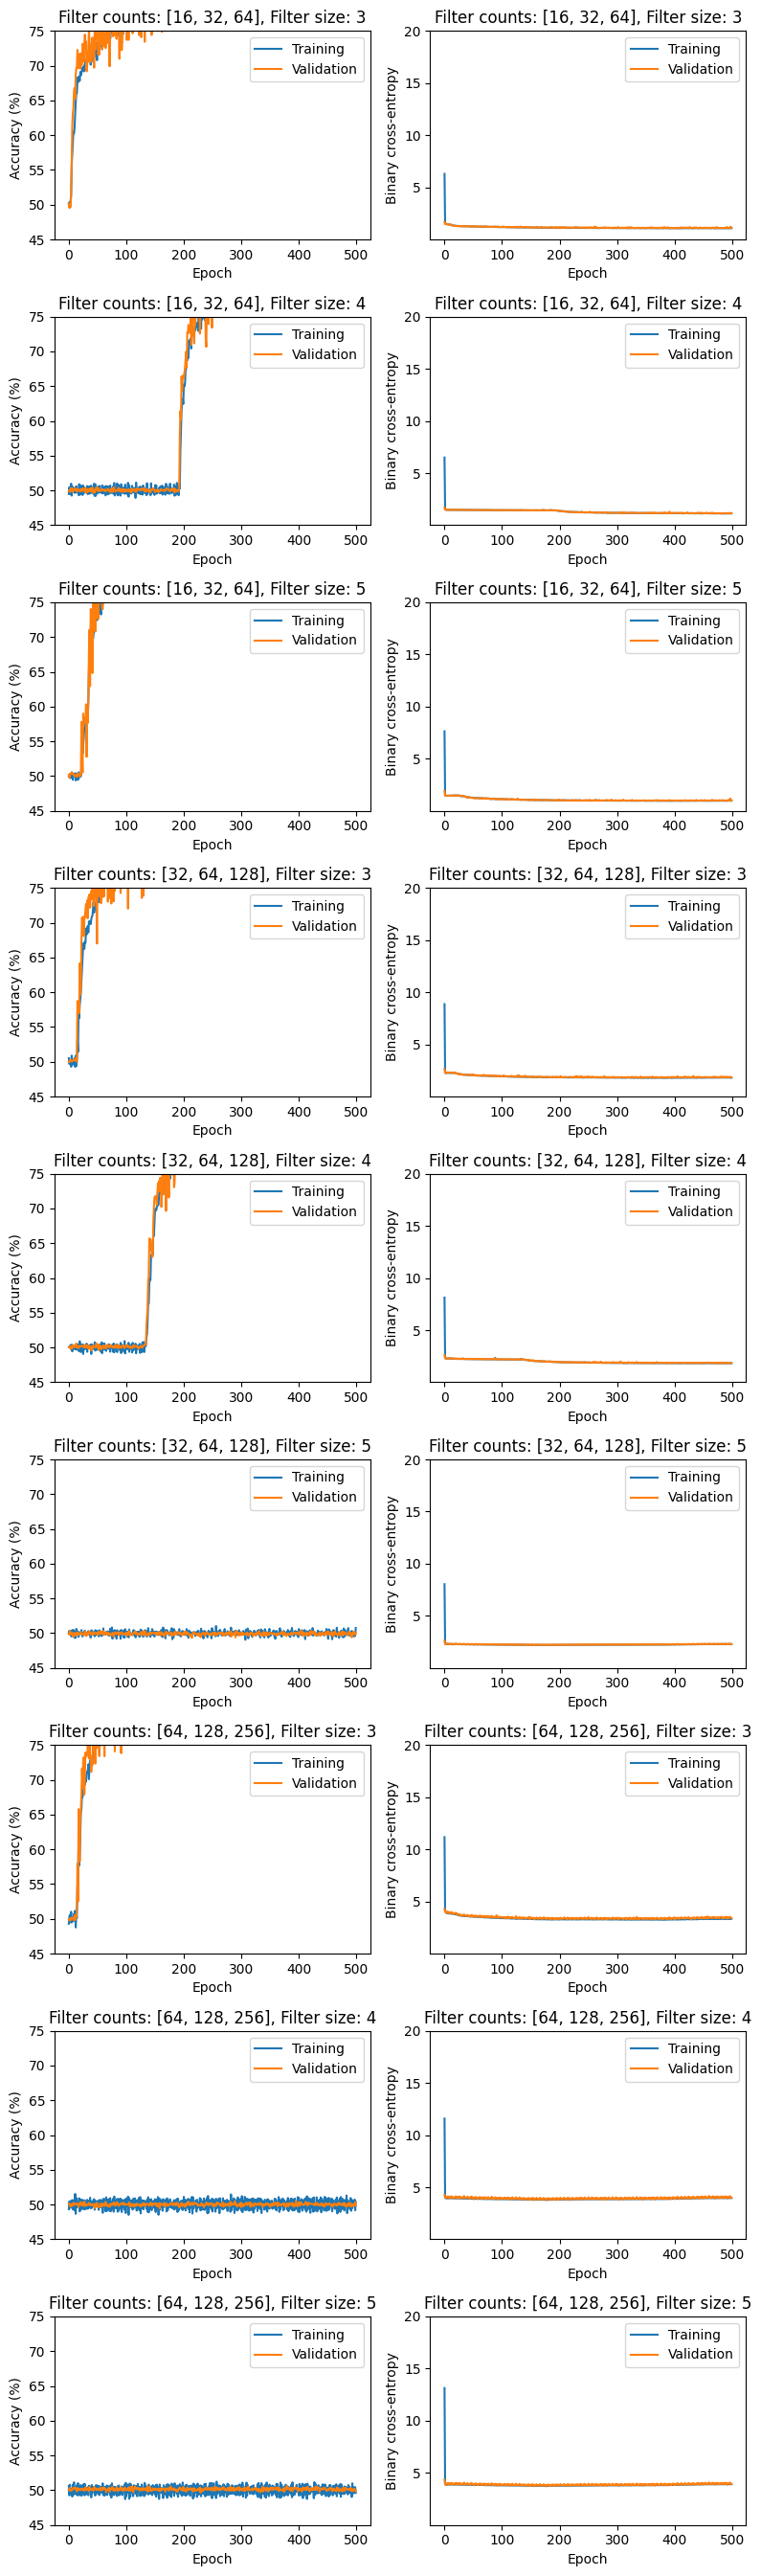


CPU times: user 2d 17h 49min 49s, sys: 8h 18min 18s, total: 3d 2h 8min 7s
Wall time: 2d 1h 30s


In [ ]:
%%time

# Define hyperparameters
hyperparameters={
    'filter_nums_list': [[16,32,64],[32,64,128],[64,128,256]],
    'filter_sizes': [3,4,5],
    'l1_penalties': [l1_penalty],
    'l2_penalties': [l2_penalty],
    'batch_sizes': [batch_size],
    'learning_rates': [learning_rate],
    'image_widths': [image_width],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 500
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['filter_nums_list', 'filter_sizes']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,100],
    entropy_ylims=[0.01,5.0]
).show()

print()

In [22]:
filter_nums=[128,256,512]
filter_size=6

In [23]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'filter_nums': filter_nums,
    'filter_size': filter_size,
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'image_height': image_height,
    'image_width': image_width,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 1000
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Plot the results
plot_single_training_run(training_results).show()

print()

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_19/conv2d_29/BiasAdd/BiasAddGrad' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1157385/3721590806.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', "\n# Set some hyperparameters for the run\nhyperparameters={\n    'filter_nums': filter_nums,\n    'filter_size': filter_size,\n    'l1_penalty': l1_penalty,\n    'l2_penalty': l2_penalty,\n    'batch_size': batch_size,\n    'learning_rate': learning_rate,\n    'image_height': image_height,\n    'image_width': image_width,\n    'steps_per_epoch': steps_per_epoch,\n    'validation_steps': validation_steps,\n    'epochs': 1000\n}\n\n# Do a single training run\ntraining_results=single_training_run(\n    training_data_path,\n    validation_data_path,\n    **hyperparameters\n)\n\n# Plot the results\nplot_single_training_run(training_results).show()\n\nprint()\n")
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2478, in run_cell_magic
      result = fn(*args, **kwargs)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1325, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 17, in <module>
    File "/mnt/arkk/4geeks_repos/24-image-classification/src/image_classification_functions.py", line 262, in single_training_run
      training_result=model.fit(
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_19/conv2d_29/BiasAdd/BiasAddGrad'
OOM when allocating tensor with shape[65536,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_19/conv2d_29/BiasAdd/BiasAddGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2005373]

## 4. Model performance

### 4.1. Train model with final parameters

In [24]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'filter_nums': filter_nums,
    'filter_size': filter_size,
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'image_height': image_height,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 1000
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Plot the results
plot_single_training_run(training_results).show()

print()

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_21/max_pooling2d_32/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1157385/3895080013.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', "\n# Set some hyperparameters for the run\nhyperparameters={\n    'filter_nums': filter_nums,\n    'filter_size': filter_size,\n    'l1_penalty': l1_penalty,\n    'l2_penalty': l2_penalty,\n    'image_height': image_height,\n    'image_width': image_width,\n    'batch_size': batch_size,\n    'learning_rate': learning_rate,\n    'steps_per_epoch': steps_per_epoch,\n    'validation_steps': validation_steps,\n    'epochs': 1000\n}\n\n# Do a single training run\ntraining_results=single_training_run(\n    training_data_path,\n    validation_data_path,\n    **hyperparameters\n)\n\n# Plot the results\nplot_single_training_run(training_results).show()\n\nprint()\n")
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2478, in run_cell_magic
      result = fn(*args, **kwargs)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1325, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 17, in <module>
    File "/mnt/arkk/4geeks_repos/24-image-classification/src/image_classification_functions.py", line 262, in single_training_run
      training_result=model.fit(
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/engine/training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "/mnt/arkk/4geeks_repos/24-image-classification/.venv-GPU/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_21/max_pooling2d_32/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[128,512,48,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_21/max_pooling2d_32/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2007609]

### 4.2. Testing dataset

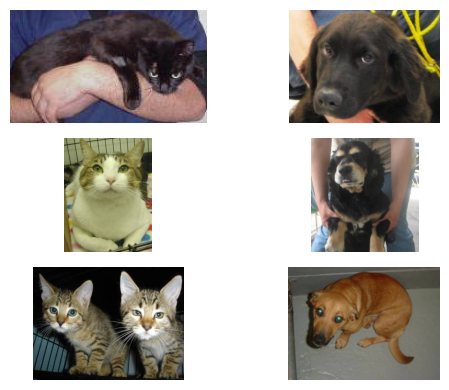

In [25]:
# Get lists of testing dog and cat images
testing_dogs=glob.glob(f'{testing_data_path}/dogs/dog.*')
testing_cats=glob.glob(f'{testing_data_path}/cats/cat.*')

# Plot some of the cat and dog images
fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(testing_cats, testing_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

In [26]:
testing_dataset=tf.keras.utils.image_dataset_from_directory(
    testing_data_path,
    image_size=(image_height, image_width)
)

### 4.3. Test set performance

In [27]:
images=np.concatenate([x for x, y in testing_dataset], axis=0)
labels=np.concatenate([y for x, y in testing_dataset], axis=0)
print(f'Testing images shape: {images.shape}')
print(f'Testing labels shape: {labels.shape}')

predictions=training_results.model.predict(images)

threshold=0.5
predictions=[1 if p > threshold else 0 for p in predictions]

accuracy=accuracy_score(predictions, labels)*100
print(f'Accuracy: {accuracy:.1f}%')

Testing images shape: (5000, 192, 256, 3)
Testing labels shape: (5000,)
Accuracy: 50.7%


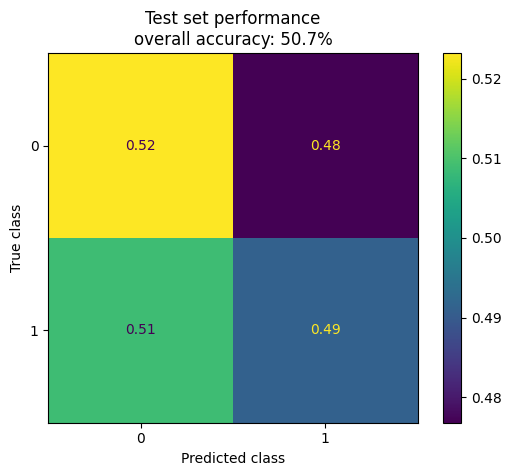

In [28]:
# Plot the confusion matrix
cm=confusion_matrix(labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()